<a href="https://colab.research.google.com/github/Ammarjdawood/ai-tour-guide/blob/main/Artifact_Recognition_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input


# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Egypt Landmarks.v5i.coco.zip to Egypt Landmarks.v5i.coco.zip


In [ ]:
import zipfile
import os


# تحديد اسم الملف الذي تم رفعه للتو. لاحظ أننا نستدعي اسم الملف من قاموس 'uploaded'
# (افترض أن اسم الملف هو Egypt Landmarks.v5i.coco.zip)
# الكود ده بيستخرج أول (وغالباً الوحيد) اسم ملف تم رفعه
zip_filename = next(iter(uploaded))
zip_path = os.path.join("/content/", zip_filename) # كده المسار بيكون /content/Egypt Landmarks.v5i.coco.zip

extract_path = "/content/dataset"

# إنشاء مجلد الاستخراج إذا لم يكن موجوداً
os.makedirs(extract_path, exist_ok=True)

try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    print("✅ تم فك ضغط الملف بنجاح إلى:", extract_path)

except FileNotFoundError:
    print(f"❌ خطأ: لم يتم العثور على الملف في المسار: {zip_path}")
except Exception as e:
    print(f"❌ حدث خطأ أثناء فك الضغط: {e}")

✅ تم فك ضغط الملف بنجاح إلى: /content/dataset


In [ ]:
import os
import json
import shutil

# المسارات
dataset_path = "dataset/train"   # مكان الصور والأنوتيشنز
annotation_file = os.path.join(dataset_path, "_annotations.coco.json")

output_dir = "dataset_classification1"

# اقرأ الأنوتيشنز
with open(annotation_file, "r") as f:
    coco = json.load(f)

images = {img["id"]: img["file_name"] for img in coco["images"]}
categories = {cat["id"]: cat["name"] for cat in coco["categories"]}

# اربط كل صورة بالكلاس بتاعها
image_to_class = {}
for ann in coco["annotations"]:
    img_id = ann["image_id"]
    cat_id = ann["category_id"]
    image_to_class[images[img_id]] = categories[cat_id]

# انسخ الصور للمكان الجديد
for img, lbl in image_to_class.items():
    src = os.path.join(dataset_path, img)
    dst_dir = os.path.join(output_dir, lbl)
    os.makedirs(dst_dir, exist_ok=True)
    shutil.copy(src, os.path.join(dst_dir, img))

print("✅ Dataset للتصنيف جاهز في:", output_dir)


✅ Dataset للتصنيف جاهز في: dataset_classification1


In [ ]:
import os
import pandas as pd

dataset_path = "dataset_classification1"

data = []
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if not os.path.isdir(class_dir):
        continue

    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        data.append((img_path, class_name))

df = pd.DataFrame(data, columns=["filepath", "label"])
print(df.head())
print("عدد الصور:", len(df))
print("عدد الكلاسات:", df['label'].nunique())


                                            filepath            label
0  dataset_classification1/Hatshepsut-face/images...  Hatshepsut-face
1  dataset_classification1/Hatshepsut-face/65_jpg...  Hatshepsut-face
2  dataset_classification1/Hatshepsut-face/images...  Hatshepsut-face
3  dataset_classification1/Hatshepsut-face/45_jpg...  Hatshepsut-face
4  dataset_classification1/Hatshepsut-face/11_jpg...  Hatshepsut-face
عدد الصور: 6861
عدد الكلاسات: 22


In [ ]:
df.shape

(6861, 2)

In [ ]:
df.head()

,filepath,label
0,dataset_classification1/Hatshepsut-face/images...,Hatshepsut-face
1,dataset_classification1/Hatshepsut-face/65_jpg...,Hatshepsut-face
2,dataset_classification1/Hatshepsut-face/images...,Hatshepsut-face
3,dataset_classification1/Hatshepsut-face/45_jpg...,Hatshepsut-face
4,dataset_classification1/Hatshepsut-face/11_jpg...,Hatshepsut-face


In [ ]:
df['label'].unique()

array(['Hatshepsut-face', 'Statue-of-Tutankhamun-with-Ankhesenamun',
       'Colossoi-of-Memnon', 'Ramessum', 'Mask-of-Tutankhamun', 'sphinx',
       'The-Great-Temple-of-Ramesses-II', 'Temple_of_Isis_in_Philae',
       'Akhenaten', 'amenhotep-iii-and-tiye', 'Statue-of-King-Zoser',
       'Ramses-II-Red-Granite-Statue', 'Colossal-Statue-of-Ramesses-II',
       'Temple_of_Kom_Ombo', 'Bent-pyramid-for-senefru',
       'Pyramid_of_Djoser', 'Goddess-Isis-with-her-child',
       'menkaure-pyramid', 'bust-of-ramesses-ii', 'Hatshepsut',
       'Nefertiti', 'Khafre-Pyramid'], dtype=object)

In [ ]:
train_df, test_valid_df = train_test_split(df, test_size=0.2, shuffle = True,
                                           random_state=42, stratify=df['label'])
valid_df, test_df = train_test_split(test_valid_df, test_size=0.5, shuffle = True,
                                           random_state=42, stratify=test_valid_df['label'])

In [ ]:
gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range = 5,
    zoom_range = 0.02,
    width_shift_range = 0.05,
    height_shift_range = 0.05,
    shear_range = 0.05,
    horizontal_flip=True,
    brightness_range=[0.95, 1.01],
    fill_mode = 'nearest',
)

train_gen = gen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='label',
    target_size = (224, 224),
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle = True,
    batch_size = 8
)

test_gen = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_dataframe(
    test_df,
    x_col='filepath',
    y_col='label',
    target_size = (224, 224),
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle = False,
    batch_size = 4
)

valid_gen = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_dataframe(
    valid_df,
    x_col='filepath',
    y_col='label',
    target_size = (224, 224),
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle = False,
    batch_size = 4
)

Found 5488 validated image filenames belonging to 22 classes.
Found 687 validated image filenames belonging to 22 classes.
Found 686 validated image filenames belonging to 22 classes.


In [ ]:
from tensorflow.keras.layers import Input

base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    pooling='max'
)

model = Sequential([
    Input(shape=(224, 224, 3)),
    base_model,
    BatchNormalization(),
    Dense(128,
          activation='relu',
          kernel_regularizer=regularizers.l2(0.001)
    ),

    Dropout(rate=0.5),

    Dense(128,
          activation='relu',
          kernel_regularizer=regularizers.l2(0.001)
    ),

    Dropout(rate=0.4),

    Dense(22, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 22)             │         2,838 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,877,526 (91.09 MB)

 Trainable params: 23,820,310 (90.87 MB)

 Non-trainable params: 57,216 (223.50 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    "best_resnet50.h5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

history = model.fit(
    train_gen,
    epochs=50,
    validation_data=valid_gen,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/50
686/686 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.2720 - loss: 3.1546
Epoch 1: val_loss improved from inf to 0.93393, saving model to best_resnet50.h5


686/686 ━━━━━━━━━━━━━━━━━━━━ 181s 176ms/step - accuracy: 0.2723 - loss: 3.1535 - val_accuracy: 0.8455 - val_loss: 0.9339
Epoch 2/50
686/686 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.6788 - loss: 1.4681
Epoch 2: val_loss improved from 0.93393 to 0.77893, saving model to best_resnet50.h5


686/686 ━━━━━━━━━━━━━━━━━━━━ 116s 168ms/step - accuracy: 0.6788 - loss: 1.4680 - val_accuracy: 0.8980 - val_loss: 0.7789
Epoch 3/50
686/686 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.7875 - loss: 1.1038
Epoch 3: val_loss improved from 0.77893 to 0.70060, saving model to best_resnet50.h5


686/686 ━━━━━━━━━━━━━━━━━━━━ 117s 170ms/step - accuracy: 0.7875 - loss: 1.1038 - val_accuracy: 0.9169 - val_loss: 0.7006
Epoch 4/50
686/686 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.8422 - loss: 0.9026
Epoch 4: val_loss did not improve from 0.70060
686/686 ━━━━━━━━━━━━━━━━━━━━ 112s 164ms/step - accuracy: 0.8422 - loss: 0.9026 - val_accuracy: 0.9227 - val_loss: 0.7597
Epoch 5/50
686/686 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.8783 - loss: 0.8148
Epoch 5: val_loss improved from 0.70060 to 0.54646, saving model to best_resnet50.h5


686/686 ━━━━━━━━━━━━━━━━━━━━ 143s 165ms/step - accuracy: 0.8783 - loss: 0.8147 - val_accuracy: 0.9694 - val_loss: 0.5465
Epoch 6/50
686/686 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.8957 - loss: 0.7262
Epoch 6: val_loss did not improve from 0.54646
686/686 ━━━━━━━━━━━━━━━━━━━━ 112s 163ms/step - accuracy: 0.8957 - loss: 0.7262 - val_accuracy: 0.9213 - val_loss: 0.8219
Epoch 7/50
686/686 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.8865 - loss: 0.7642
Epoch 7: val_loss did not improve from 0.54646
686/686 ━━━━━━━━━━━━━━━━━━━━ 110s 160ms/step - accuracy: 0.8865 - loss: 0.7642 - val_accuracy: 0.9344 - val_loss: 0.6016
Epoch 8/50
686/686 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9164 - loss: 0.6470
Epoch 8: val_loss did not improve from 0.54646
686/686 ━━━━━━━━━━━━━━━━━━━━ 142s 161ms/step - accuracy: 0.9164 - loss: 0.6470 - val_accuracy: 0.9475 - val_loss: 0.5681
Epoch 9/50
686/686 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9138 - loss: 0.6941
Epoch 9: val_loss impro

686/686 ━━━━━━━━━━━━━━━━━━━━ 115s 168ms/step - accuracy: 0.9138 - loss: 0.6941 - val_accuracy: 0.9592 - val_loss: 0.4973
Epoch 10/50
686/686 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9286 - loss: 0.5954
Epoch 10: val_loss did not improve from 0.49731
686/686 ━━━━━━━━━━━━━━━━━━━━ 110s 160ms/step - accuracy: 0.9286 - loss: 0.5954 - val_accuracy: 0.9052 - val_loss: 1.0952
Epoch 11/50
686/686 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9374 - loss: 0.5792
Epoch 11: val_loss did not improve from 0.49731
686/686 ━━━━━━━━━━━━━━━━━━━━ 111s 161ms/step - accuracy: 0.9374 - loss: 0.5792 - val_accuracy: 0.9665 - val_loss: 0.4980
Epoch 12/50
686/686 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9322 - loss: 0.5791
Epoch 12: val_loss did not improve from 0.49731
686/686 ━━━━━━━━━━━━━━━━━━━━ 110s 161ms/step - accuracy: 0.9322 - loss: 0.5791 - val_accuracy: 0.9519 - val_loss: 0.5317
Epoch 13/50
686/686 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9523 - loss: 0.4822
Epoch 13: val_lo

In [ ]:
train_score = model.evaluate(train_gen)
test_score = model.evaluate(test_gen)

print("Train Accuracy: ", train_score[1])
print("Test Accuracy: ", test_score[1])

686/686 ━━━━━━━━━━━━━━━━━━━━ 93s 131ms/step - accuracy: 0.9905 - loss: 0.3685
172/172 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.9686 - loss: 0.4512
Train Accuracy:  0.9866982698440552
Test Accuracy:  0.9679766893386841


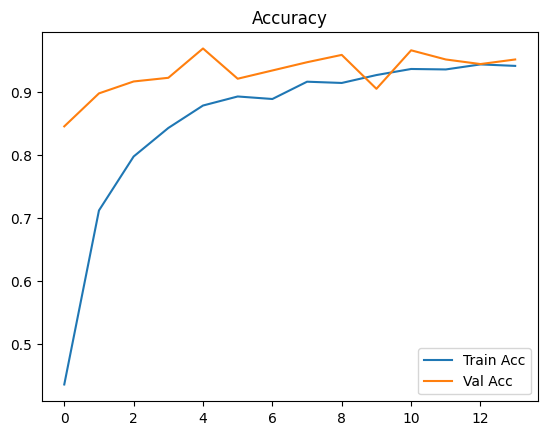

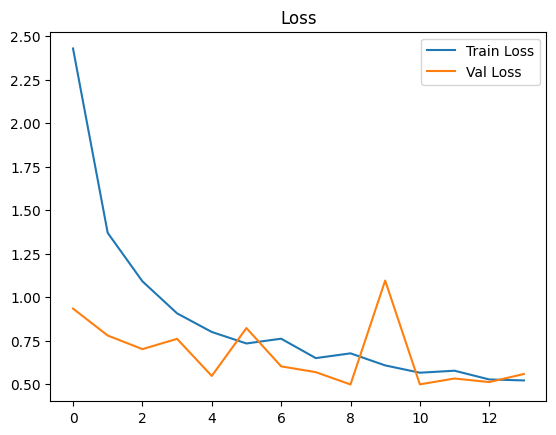

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()


⏳ جاري الحصول على تنبؤات مجموعة التحقق...
172/172 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step

======== تقرير التصنيف (Classification Report) ========
                                         precision    recall  f1-score   support

                              Akhenaten       0.90      0.95      0.92        19
               Bent-pyramid-for-senefru       0.90      0.98      0.94        65
         Colossal-Statue-of-Ramesses-II       0.95      1.00      0.97        18
                     Colossoi-of-Memnon       0.98      1.00      0.99        44
            Goddess-Isis-with-her-child       1.00      1.00      1.00        16
                             Hatshepsut       0.92      0.98      0.95        61
                        Hatshepsut-face       1.00      1.00      1.00        16
                         Khafre-Pyramid       0.96      0.96      0.96        94
                    Mask-of-Tutankhamun       1.00      1.00      1.00        38
                              Nefertiti       0.

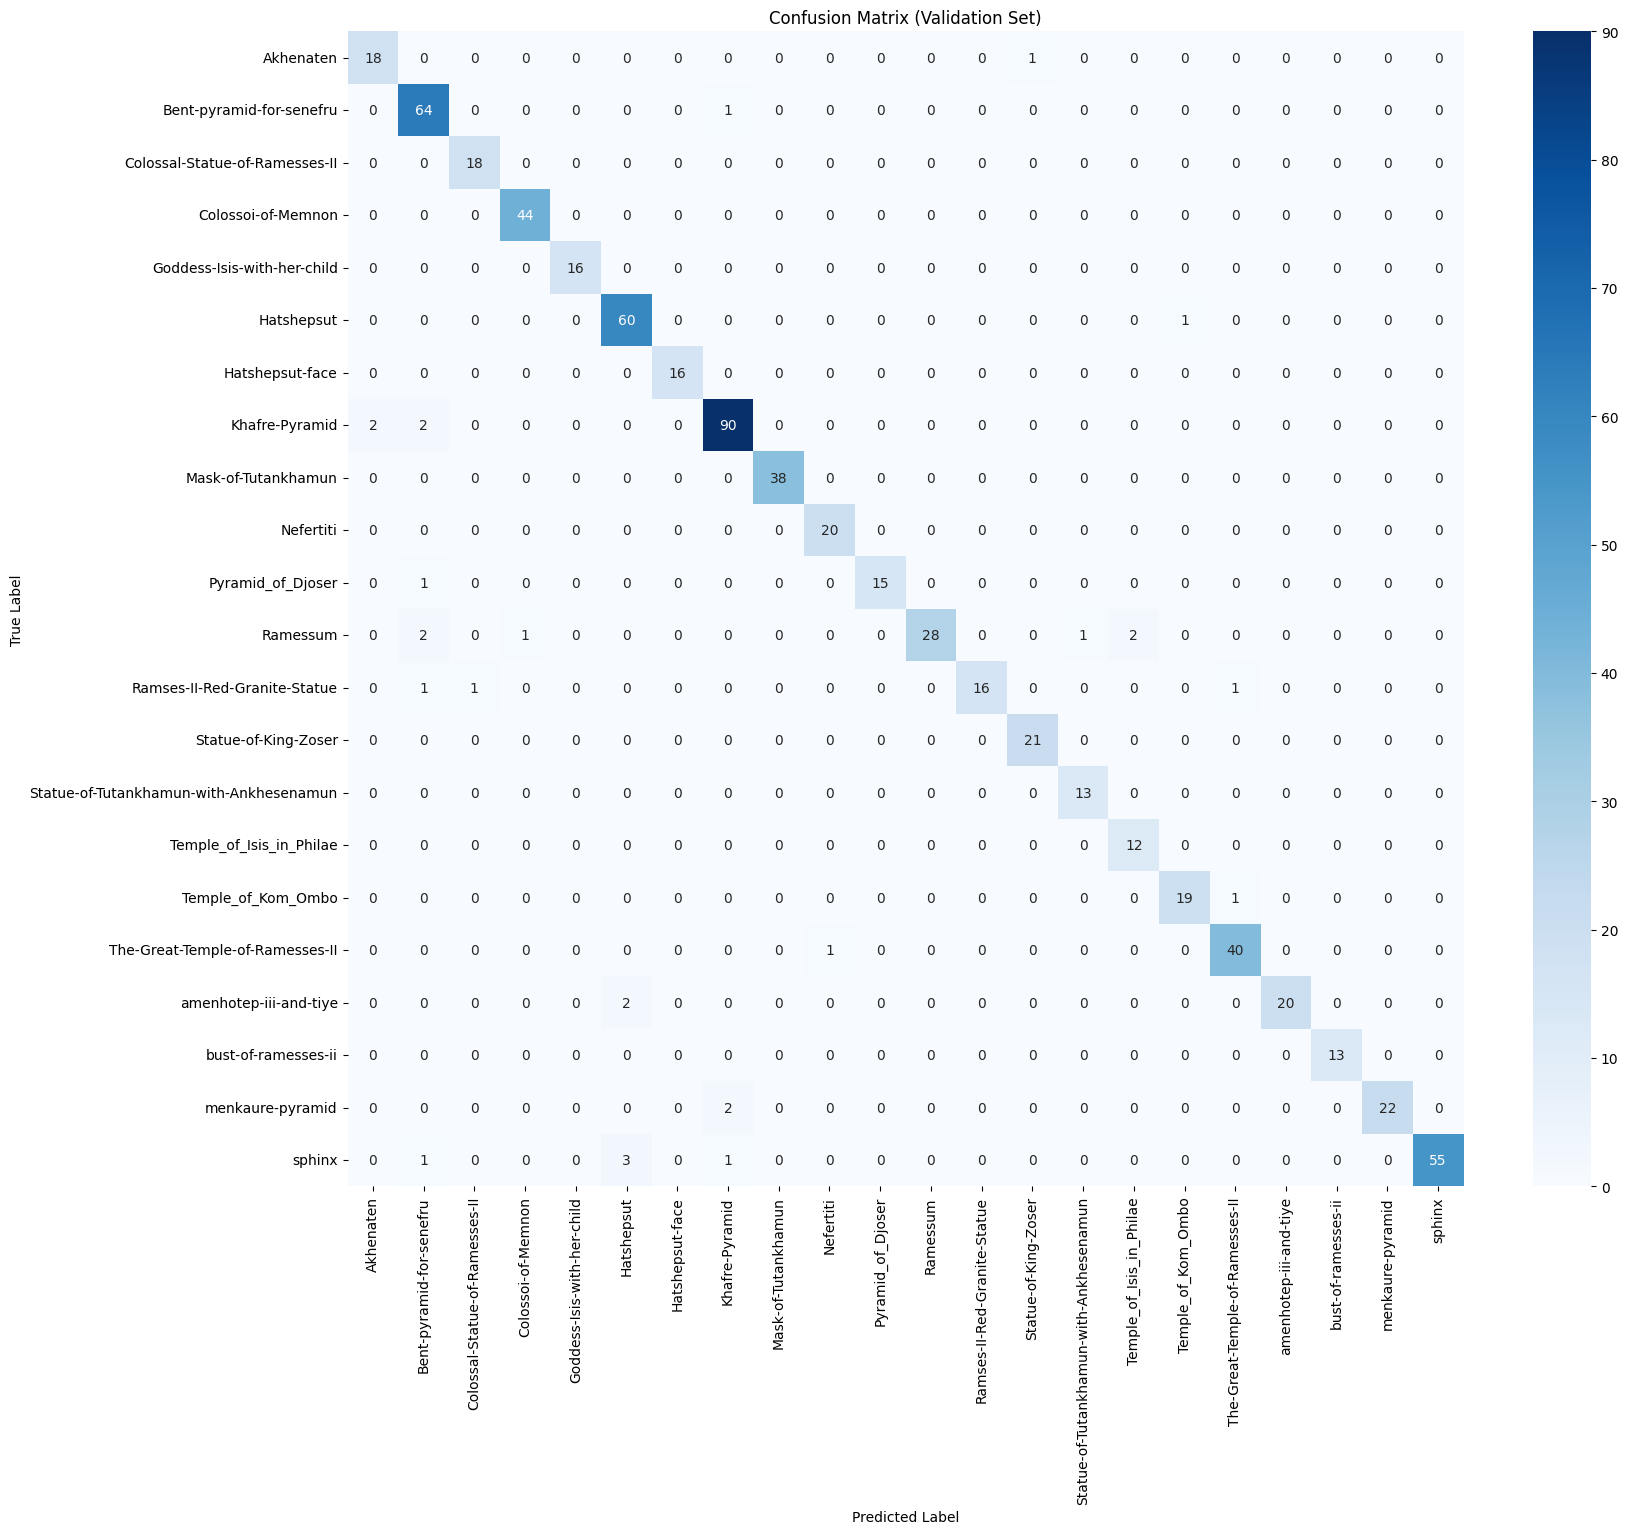


✅ اكتمل التقييم. ركّز على F1-Score لكل فئة في التقرير.


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("⏳ جاري الحصول على تنبؤات مجموعة التحقق...")
Y_pred = model.predict(valid_gen)
Y_pred_classes = np.argmax(Y_pred, axis=1)

valid_gen.reset()
Y_true = valid_gen.classes
class_names = list(valid_gen.class_indices.keys())

print("\n======== تقرير التصنيف (Classification Report) ========")
print(classification_report(Y_true, Y_pred_classes, target_names=class_names))

conf_matrix = confusion_matrix(Y_true, Y_pred_classes)

plt.figure(figsize=(18, 15))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Validation Set)')
plt.show()

print(f"\n✅ اكتمل التقييم. ركّز على F1-Score لكل فئة في التقرير.")

In [ ]:
files.download("best_resnet50.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>